# SVM for Digits

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as skl_svm
from sklearn.cross_validation import train_test_split
import seaborn as sns
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Digits')

In [2]:
digit_data = pd.read_csv('Data/train.csv')

In [3]:
X = digit_data.ix[:,1:digit_data.shape[1]]
y = digit_data['label']

In [4]:
X_subset = X.ix[0:5000,:]
y_subset = y.ix[0:5000]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.1)

In [5]:
lin_svc_clf = skl_svm.SVC(kernel='linear')
lin_svc_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
y_pred = lin_svc_clf.predict(X_test)
test_accuracy = pd.Series(y_pred == y_test).map(lambda x: 1 if x else 0).mean()
print 'Accuracy: ', test_accuracy

Accuracy:  0.90618762475


The accuracy of a simple linear SVM is ~0.9, which is fairly good. Let's look at some instances where the SVM got it wrong:

## Incorrectly classified instances:

C:\Users\Lundi\Miniconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


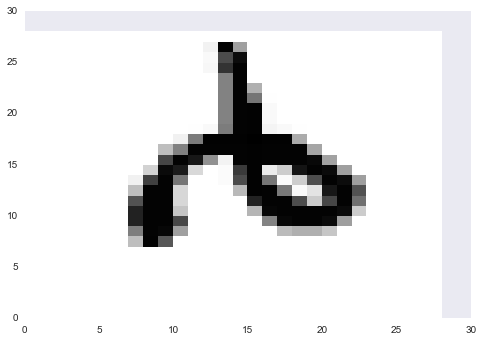

In [7]:
incorrect_indexes = ~(y_pred == y_test)
incorrect_X = X_test.ix[incorrect_indexes,:]
incorrect_X_reshape = map(lambda x: x.reshape(28,28), incorrect_X.values)
incorrect_y_pred = y_pred[incorrect_indexes.values]
incorrect_y_test = y_test.values[incorrect_indexes.values]

incorrect_matrix = pd.DataFrame({'Actual': incorrect_y_test, 'Predicted' : incorrect_y_pred}, columns=['Actual','Predicted'])

for incorrect_index in xrange(incorrect_X.shape[0]):
    #print 'Actual: ', incorrect_y_test[incorrect_index]
    #print 'Predicted: ', incorrect_y_pred[incorrect_index]
    plt.pcolor(incorrect_X_reshape[incorrect_index].T)

#### Heatmap of incorrect classified numbers

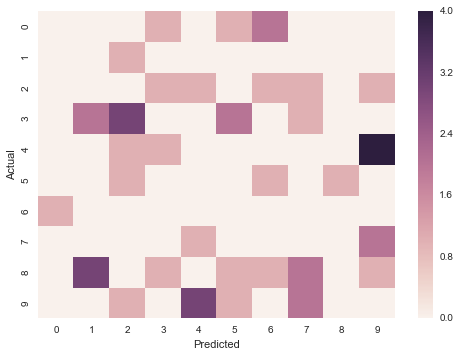

In [8]:
incorrect_matrix.head(2)

crosstab_incorrect_matrix = pd.crosstab(incorrect_y_test, incorrect_y_pred, rownames = ['Actual'], colnames=['Predicted'])
sns.heatmap(crosstab_incorrect_matrix)

The most comment error is actual 8s being classified as 3s. Also common are 3s that are classified as 6s. 

Common errors:

Actual --> Predict

8      --> 3

3      --> 5

3      --> 6


## Grid Search with Linear Kernel SVM

Let's see if doing a grid search with the linear SVM can improve things:

In [13]:
import time
from sklearn.grid_search import GridSearchCV

In [13]:

lin_svc_clf = skl_svm.SVC()

#, 'degree': np.arange(1,4), 
lin_svc_gs_params = [
    {'kernel': ['linear'], 'C': [1]}
]
start_time = time.time()
gs_lin_svc_clf = GridSearchCV(lin_svc_clf, param_grid = lin_svc_gs_params, cv=6)
gs_lin_svc_clf.fit(X_subset, y_subset);
end_time = time.time()

print 'Elapsed Time: ', end_time - start_time, ' seconds'

Elapsed Time:  22.9830000401


In [14]:
for params, mean_score, scores in gs_lin_svc_clf.grid_scores_:
    print('%0.3f+/-%0.3f %r' % (mean_score, np.std(scores), params))

0.913+/-0.011 {'kernel': 'linear', 'C': 1}


No major difference between C values. Let's look at different gammas:

In [53]:
lin_svc_gs_params = [
    {'kernel': ['linear'], 'C': [1], 'gamma': np.logspace(-2,2, num=5)}
]

gs_lin_svc_clf = GridSearchCV(lin_svc_clf, param_grid = lin_svc_gs_params, cv=10, n_jobs=4)
gs_lin_svc_clf.fit(X_subset, y_subset);

In [54]:
for params, mean_score, scores in gs_lin_svc_clf.grid_scores_:
    print('%0.3f+/-%0.3f %r' % (mean_score, np.std(scores), params))

0.918+/-0.012 {'kernel': 'linear', 'C': 1, 'gamma': 0.01}
0.918+/-0.012 {'kernel': 'linear', 'C': 1, 'gamma': 0.10000000000000001}
0.918+/-0.012 {'kernel': 'linear', 'C': 1, 'gamma': 1.0}
0.918+/-0.012 {'kernel': 'linear', 'C': 1, 'gamma': 10.0}
0.918+/-0.012 {'kernel': 'linear', 'C': 1, 'gamma': 100.0}


No major difference here. 

### Duh: Linear kernel don't use degrees (that's for poly)

Let's look at different kernels:

In [14]:
svc_gs_params = [
    {'kernel': ['poly'], 'degree': np.arange(1,3), 'C': np.logspace(-2, 10, num=7)}, 
    {'kernel': ['rbf'], 'gamma': np.logspace(-9, 3, num=7), 'C': np.logspace(-2, 10, num=7)},
    {'kernel': ['sigmoid'], 'C': np.logspace(-2, 10, num=7)}
]
start_time = time.time()
gs_svc_clf = GridSearchCV(lin_svc_clf, param_grid = svc_gs_params, cv=5)
gs_svc_clf.fit(X_subset, y_subset);
end_time = time.time()

print 'Elapsed Time: ', end_time - start_time, ' seconds'

Elapsed Time:  6611.52399993  seconds


In [15]:
for params, mean_score, scores in gs_svc_clf.grid_scores_:
    print('%0.3f+/-%0.3f %r' % (mean_score, np.std(scores), params))

0.910+/-0.007 {'kernel': 'poly', 'C': 0.01, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 0.01, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 1.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 1.0, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 100.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 100.0, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 10000.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 10000.0, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 1000000.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 1000000.0, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 100000000.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 100000000.0, 'degree': 2}
0.910+/-0.006 {'kernel': 'poly', 'C': 10000000000.0, 'degree': 1}
0.951+/-0.007 {'kernel': 'poly', 'C': 10000000000.0, 'degree': 2}
0.112+/-0.000 {'kernel': 'rbf', 'C': 0.01, 'gamma': 1.0000000000000001e-09}
0.294+/-0.008 {'kernel': 'rbf', 'C': 0.01, 'gamma': 9.9999999999999995e-08}
0.

## Investigating polynomial SVC

The polynomial support vector classifiers did fairly well on average. Let's look deeper into these:

In [ ]:
svc_poly_gs_params = [
    {'kernel': ['poly'], 'degree': np.arange(1,6), 'C': np.logspace(-2, 10, num=13)}, 
]
start_time = time.time()
gs_svc_poly_clf = GridSearchCV(lin_svc_clf, param_grid = svc_gs_params, cv=8)
gs_svc_poly_clf.fit(X_subset, y_subset);
end_time = time.time()

print 'Elapsed Time: ', end_time - start_time, ' seconds'

for params, mean_score, scores in gs_svc_poly_clf.grid_scores_:
    print('%0.3f+/-%0.3f %r' % (mean_score, np.std(scores), params))